In [159]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas
import montecarlo as mc
import seaborn as sns
import panel as pn
from panel.interact import interact
import random
from iexfinance.stocks import get_historical_data
import iexfinance as iex


In [160]:
tickers_dict = {"index":["VOO"],
                "crypto":['BTC', 'ETH', 'XRP']}
years = 2
data_start_date = datetime.now() + timedelta(-365*years)

In [161]:
portfolio_hist_prices = mc.get_historic_data(ticker = tickers_dict["index"], 
                                             start_date = data_start_date)
#portfolio_hist_prices.head()

In [162]:
btc_daily_price = mc.get_crypto_daily_price(tickers_dict["crypto"],limit=years*365)
#btc_daily_price.head()

In [163]:
portfolio_hist_prices = pd.concat([portfolio_hist_prices,btc_daily_price],axis=1,join="inner")
portfolio_hist_prices.dropna(inplace=True)
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.head()

In [164]:
portfolio_hist_prices = mc.normalize_dataframe(portfolio_hist_prices)
portfolio_daily_retn = portfolio_hist_prices.pct_change().copy()

#portfolio_daily_retn

In [165]:
def corr_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    correlated = portfolio_daily_retn.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlated, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    correlated_plot, ax = plt.subplots(figsize=(6, 4))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlated, mask=mask, cmap="coolwarm", vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, annot=True
                #cbar_kws={"shrink": .5}
               )
    plt.title(f"Correlation Map of Portfolio\n",fontdict=title_font)
    ax.set_facecolor("aliceblue")
    
    #correlated_plot = sns.heatmap(correlated, vmin=-1, vmax=1, annot=True,cmap="coolwarm") 
    plt.close()
    return pn.Pane(correlated_plot)

In [180]:
def sharp_rt_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    label_font = {'family': 'monospace',
            'color':  'green',
            'weight': 'bold',
            'size': 12,
            }
   # bar_colors=["orange","plum","yellowgreen","indigo","wheat","salmon","lightblue","purple","gold",
    #           "cornflowerblue","mediumslateblue","seagreen","peru"]
    bar_colors=["midnightblue","royalblue","indigo","darkcyan","darkgreen","maroon",
               "purple","darkorange","slategray","forestgreen"]

    sharp_ratios = portfolio_daily_retn.mean()*np.sqrt(252)/portfolio_daily_retn.std()
    
    sr_plot = plt.figure();
    plt.bar(x = sharp_ratios.index, height=sharp_ratios, color=random.sample(bar_colors,len(sharp_ratios.index)))
    plt.title(f"Sharp Ratios of Portfolio\n",fontdict=title_font)
    plt.ylabel("Sharp Ratio",fontdict=label_font)
    plt.xlabel("Assets",fontdict=label_font)
    plt.axhline(sharp_ratios.mean(), color='r')
    
    
    plt.close()
    return pn.Pane(sr_plot)

Matplotlib(Figure)
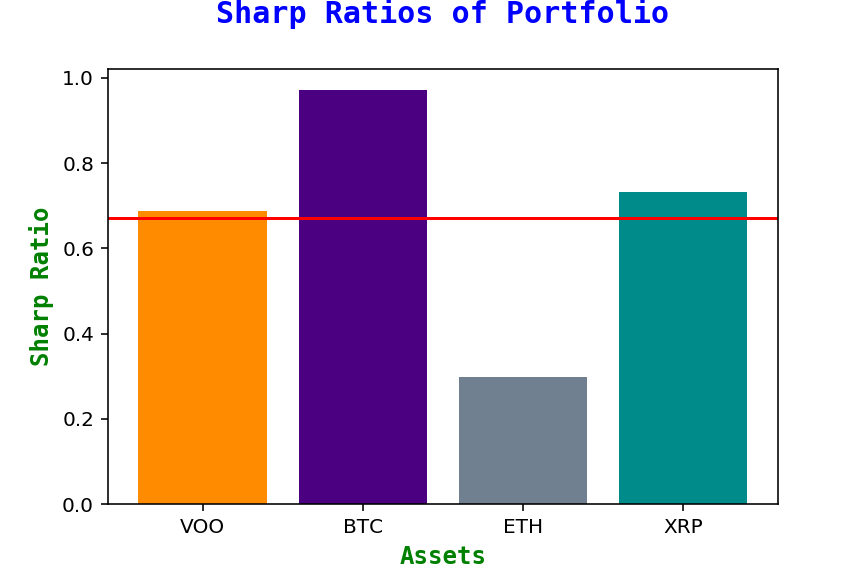

In [181]:
plot = sharp_rt_plot(portfolio_daily_retn)
plot

In [183]:


def plot_mont_carl(monte_carlo_sim):
    plot_title = f"Monte-Carlo Simulation of Portfolio"
    monte_carlo_sim_plot = monte_carlo_sim.hvplot(title=plot_title,figsize=(18,10),legend=False)
    return monte_carlo_sim_plot

In [169]:
def get_conf_interval(db,q=[0.05, 0.95]):
    confidence_interval = db.iloc[-1].quantile(q=q)
    return confidence_interval

In [170]:
def plot_conf(values=None,conf=[0,0]):
    bar_colors=["midnightblue","royalblue","indigo","black","darkcyan","darkgreen",
               "purple","darkorange","slategray"]
    conifidence_plot = plt.figure();
    #plt.plot(values,kind='hist', density=True, bins=20)
    plt.hist(x = values,bins=20, color = random.choice(bar_colors))
    plt.axvline(conf.iloc[0], color='r')
    plt.axvline(conf.iloc[1], color='r')
    plt.close()
    return pn.Pane(conifidence_plot)

In [171]:
#plot = plot_conf(values=mc_sim.iloc[-1],conf=get_conf_interval(mc_sim))
#plot

# DASHBOARD TIME!!!

In [172]:
print(portfolio_hist_prices.head())

               VOO      BTC     ETH     XRP
2017-09-18  230.49  4100.28  297.53  0.1933
2017-09-19  230.77  3907.96  283.00  0.1848
2017-09-20  229.72  3882.16  283.56  0.1817
2017-09-21  229.07  3617.27  257.77  0.1710
2017-09-22  229.04  3600.83  262.94  0.1728


In [173]:
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.any()
portfolio_hist_prices.head()

,VOO,BTC,ETH,XRP
2017-09-18,230.49,4100.28,297.53,0.1933
2017-09-19,230.77,3907.96,283.00,0.1848
2017-09-20,229.72,3882.16,283.56,0.1817
2017-09-21,229.07,3617.27,257.77,0.1710
2017-09-22,229.04,3600.83,262.94,0.1728


In [174]:
mc_sim = mc.monte_carlo_sim(portfolio_hist_prices,trials = 100)

In [175]:
risk_tabs = pn.Tabs(
    ("Correlation of portfolio",corr_plot(portfolio_daily_retn)),
    ("Sharp Ratios", sharp_rt_plot(portfolio_daily_retn)),
    background="whitesmoke"
)

In [176]:
montecarlo_tabs = pn.Tabs(
    ("monte Carlo Simulation",plot_mont_carl(mc_sim)),
    ("Confidence Intervals", plot_conf(mc_sim.iloc[-1],get_conf_interval(mc_sim))),
    background="whitesmoke"
)

In [177]:
techl_analysis_tabs = pn.Tabs(
    ("TA1","in construction"),
    ("TA2", "in construction"),
    background="whitesmoke"
)

In [178]:
tabs = pn.Tabs(
    ("Risk",risk_tabs),
    ("Monte Carlo Simulation", montecarlo_tabs),
    ("Tecnical Analysis", techl_analysis_tabs),
    ("Report", "in construction")
)
  

Tabs
    [0] Tabs(background='whitesmoke')
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
    [1] Tabs(background='whitesmoke')
        [0] HoloViews(NdOverlay, name='monte Carlo Simulation')
        [1] Matplotlib(Figure)
    [2] Tabs(background='whitesmoke')
        [0] Markdown(str, name='TA1')
        [1] Markdown(str, name='TA2')
    [3] Markdown(str, name='Report')
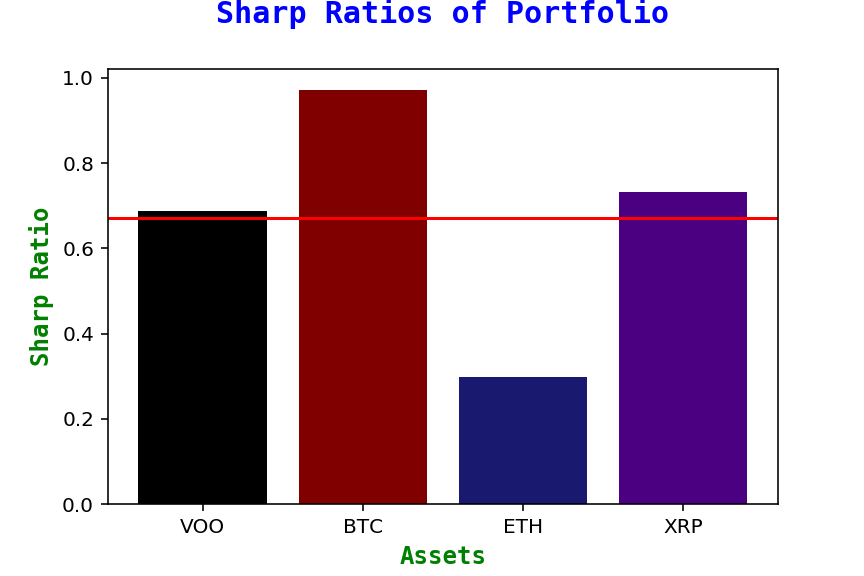
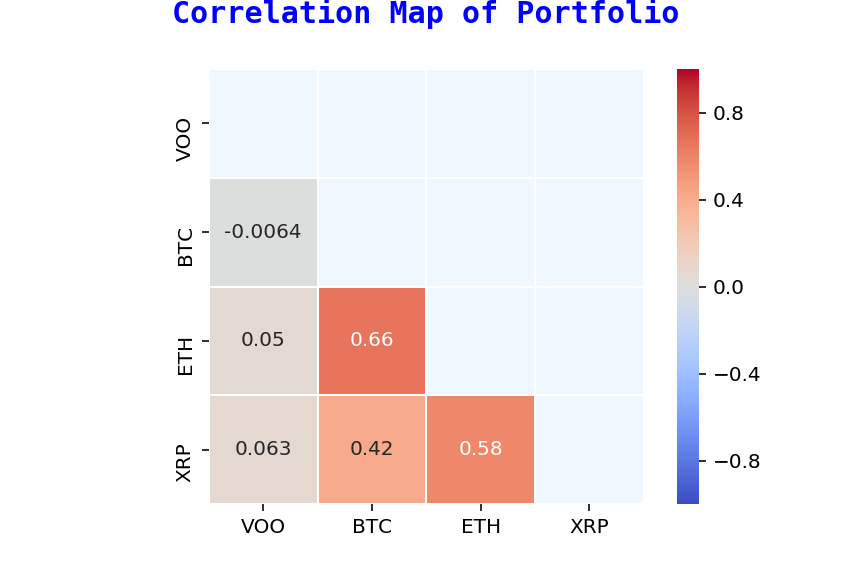
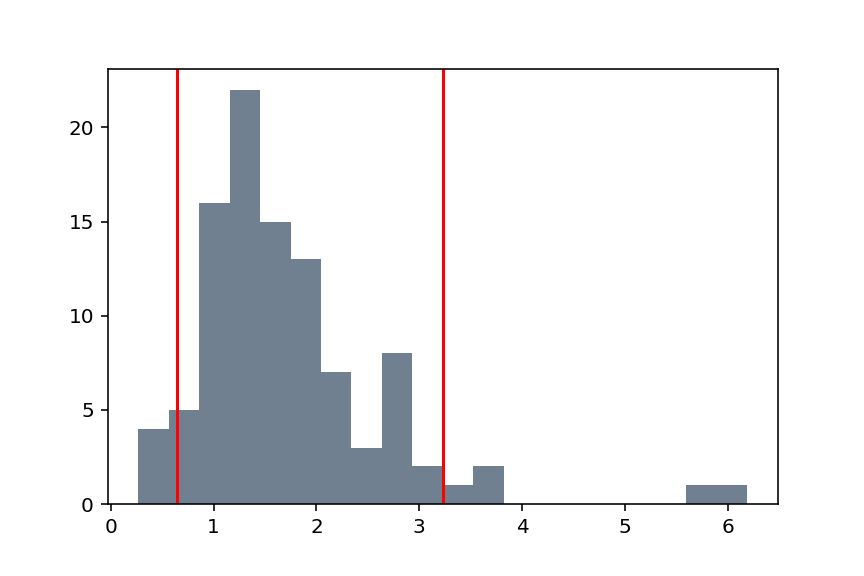

In [179]:
  
panel = tabs

panel